<a href="https://colab.research.google.com/github/Fadinrsultan/kalman_filter_simulation/blob/main/kalman_filter_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**METHOD 1:**

---
This Python script simulates projectile motion using a Kalman filter. It handles measurement dropouts by creating pseudo-measurements through an ensemble of Gaussian Process Regression, polynomial, and linear regression models. The filter predicts and updates state estimates, manages noise scaling during dropouts, calculates accuracy metrics, and visualizes the true trajectory alongside observations and estimates.


Position Accuracy: 92.94%
Velocity Accuracy: 79.85%

Sample of results (Ensemble-based Pseudo-Measurements During Dropouts):
TimeStep | TrueX     TrueY     MeasuredX     MeasuredY     EstX       EstY       TrueVX   TrueVY   EstVX    EstVY
      1 |    0.000   10.000        nan        nan    7.012   11.224  14.142  14.142   0.234  -3.852
      2 |    1.414   11.365      1.205     11.473    1.730   11.416  14.142  14.142  -0.290  -3.795
      3 |    2.828   12.632      2.243     12.693    1.978   11.884  14.142  13.161  -0.003  -2.919
      4 |    4.243   13.801      3.347     13.760    2.556   12.508  14.142  12.180   1.157  -1.082
      5 |    5.657   14.872        nan        nan    2.672   12.400  14.142  11.199   1.157  -1.082
      6 |    7.071   15.845      6.754     17.266    4.890   14.928  14.142  10.218   5.781   4.717
      7 |    8.485   16.719      8.923     18.174    7.041   16.663  14.142   9.237   8.972   7.280
      8 |    9.899   17.496     10.887     17.536    9.150   

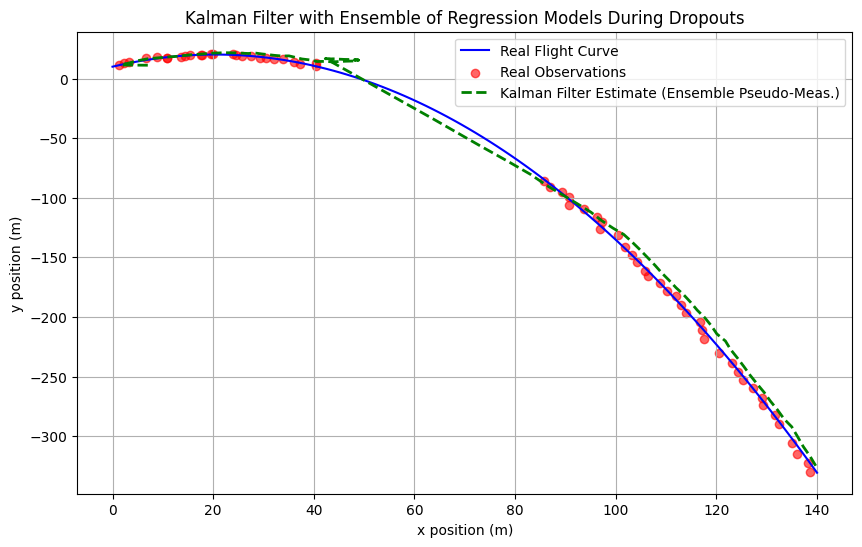

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.linear_model import LinearRegression

def simulate_kalman_filter_with_ensemble_pseudo_measurements(
    launch_height,
    launch_speed,
    launch_angle,
    measurement_noise_covariance,
    process_noise_covariance,
    initial_state_covariance,
    num_steps,
    dropout_start,
    dropout_end,
    observation_probability,
    steps_per_growth=5,    # Number of steps before increasing uncertainty
    growth_factor=2.0,     # Factor by which uncertainty increases
    window_size=5,
    poly_degree=2
):
    """
    Simulates projectile motion with a Kalman filter.
    During dropouts, trains multiple regression models (GPR, polynomial, linear regression) on past estimates
    and uses an ensemble (average) of their predictions as pseudo-measurements with exponentially increasing noise every 'steps_per_growth' steps.
    """

    # Gravity and time step
    g = 9.81
    dt = 0.1

    # True initial conditions
    x0 = 0.0
    y0 = launch_height
    vx0 = launch_speed * np.cos(np.radians(launch_angle))
    vy0 = launch_speed * np.sin(np.radians(launch_angle))
    q_true = np.array([x0, y0, vx0, vy0])

    # Since initial position and flying direction are unknown:
    # Assume the ball starts within ±10m range around the real starting position
    # and velocity is also uncertain.
    x0_guess = x0 + np.random.uniform(-10, 10)
    y0_guess = y0 + np.random.uniform(-10, 10)
    # For velocity, assume a moderate guess: we have no idea about direction, pick random from a range
    vx0_guess = np.random.uniform(-5, 5)
    vy0_guess = np.random.uniform(-5, 5)

    q_est = np.array([x0_guess, y0_guess, vx0_guess, vy0_guess])


    # State transition and observation matrices
    A = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1,  0],
        [0, 0, 0,  1]
    ])

    B = np.array([
        [0,         0],
        [0.5*dt*dt, 0],
        [0,         0],
        [dt,        0]
    ])

    u = np.array([0, -g])
    C = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    Q = process_noise_covariance
    R = measurement_noise_covariance
    R_pseudo_base = R.copy()  # Base pseudo-measurement noise covariance

    # Initial covariance
    P = np.eye(4) * initial_state_covariance

    # Arrays for storing results
    true_positions = np.zeros((num_steps, 4))
    observations = np.full((num_steps, 2), np.nan)
    estimates = np.zeros((num_steps, 4))

    true_positions[0, :] = q_true
    estimates[0, :] = q_est

    vx, vy = vx0, vy0

    def is_observation_available(t):
        return (np.random.rand() < observation_probability) and not (dropout_start <= t < dropout_end)

    # Store data for regression models
    times = [0]
    x_history = [q_est[0]]
    y_history = [q_est[1]]

    gpr_x = None
    gpr_y = None
    gpr_fitted = False

    # Instantiate linear regression models
    linear_model_x = LinearRegression()
    linear_model_y = LinearRegression()

    # Initialize dropout counter and noise scaling factor
    dropout_counter = 0
    noise_scaling_factor = 1.0  # Starts at 1.0 and increases exponentially

    for t in range(1, num_steps):
        # Update true state
        true_positions[t, 0] = true_positions[t-1, 0] + vx * dt
        true_positions[t, 1] = true_positions[t-1, 1] + vy * dt - 0.5 * g * dt**2
        true_positions[t, 2] = vx
        true_positions[t, 3] = vy
        vy = vy - g * dt

        # Check for real observation
        if is_observation_available(t):
            observations[t, 0] = true_positions[t, 0] + np.random.normal(0, np.sqrt(R[0,0]))
            observations[t, 1] = true_positions[t, 1] + np.random.normal(0, np.sqrt(R[1,1]))
            dropout_counter = 0  # Reset dropout counter when measurement is available
            noise_scaling_factor = 1.0  # Reset noise scaling factor
        else:
            if dropout_start <= t < dropout_end:
                dropout_counter += 1  # Increment dropout counter during dropout period

                # Increase noise_scaling_factor exponentially every 'steps_per_growth' steps
                if dropout_counter % steps_per_growth == 0:
                    noise_scaling_factor *= growth_factor
            else:
                dropout_counter = 0  # Not in dropout period
                noise_scaling_factor = 1.0  # Ensure scaling factor is reset

        # Prediction step
        x_pred = A @ estimates[t-1] + B @ u
        P_pred = A @ P @ A.T + Q

        if not np.isnan(observations[t, 0]):
            # We have a real measurement
            z = observations[t, :].reshape(-1, 1)
            current_R = R
        else:
            # No real measurement this step
            if dropout_start <= t < dropout_end:
                # If we haven't fit GPR yet, do it now
                if not gpr_fitted and len(times) >= window_size:
                    # Prepare training data
                    T_train = np.array(times).reshape(-1,1)
                    x_train = np.array(x_history)
                    y_train = np.array(y_history)

                    # Fit GPR
                    kernel = 1.0 * RBF(length_scale=10.0) + WhiteKernel(noise_level=1e-3)
                    gpr_x = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
                    gpr_y = GaussianProcessRegressor(kernel=kernel, alpha=0.0, normalize_y=True)
                    gpr_x.fit(T_train, x_train)
                    gpr_y.fit(T_train, y_train)
                    gpr_fitted = True

                # Fit polynomial regression if we have enough data
                if len(times) >= window_size:
                    # Take last 'window_size' points for polynomial
                    x_data = np.array(times[-window_size:])
                    x_vals = np.array(x_history[-window_size:])
                    y_vals = np.array(y_history[-window_size:])

                    px = np.polyfit(x_data, x_vals, poly_degree)
                    py = np.polyfit(x_data, y_vals, poly_degree)

                    # Fit linear regression on the same window
                    X_window = x_data.reshape(-1,1)
                    linear_model_x.fit(X_window, x_vals)
                    linear_model_y.fit(X_window, y_vals)

                    # Now predict for the current time
                    t_current = t
                    # GPR predictions
                    if gpr_fitted:
                        x_gpr_mean, _ = gpr_x.predict([[t_current]], return_std=True)
                        y_gpr_mean, _ = gpr_y.predict([[t_current]], return_std=True)
                    else:
                        # If GPR not fitted yet (not enough data?), fallback to polynomial or linear only
                        x_gpr_mean = [x_pred[0]]
                        y_gpr_mean = [x_pred[1]]

                    # Polynomial predictions
                    x_poly = np.polyval(px, t_current)
                    y_poly = np.polyval(py, t_current)

                    # Linear regression predictions
                    x_lin = linear_model_x.predict([[t_current]])[0]
                    y_lin = linear_model_y.predict([[t_current]])[0]

                    # Ensemble: simple average
                    x_ens = (x_gpr_mean[0] + x_poly + x_lin) / 3.0
                    y_ens = (y_gpr_mean[0] + y_poly + y_lin) / 3.0

                else:
                    # Not enough data to fit all models, fallback to predicted state as pseudo-measurement
                    x_ens = x_pred[0]
                    y_ens = x_pred[1]

                # Update R_pseudo with exponentially increasing uncertainty
                R_pseudo = R_pseudo_base * noise_scaling_factor

                # Add noise based on updated R_pseudo
                pseudo_measurement = np.array([x_ens, y_ens]) + np.random.multivariate_normal([0,0], R_pseudo)
                z = pseudo_measurement.reshape(-1,1)
                current_R = R_pseudo
            else:
                # Outside dropout period and no measurement
                z = None
                current_R = None

        # Update step
        if z is not None:
            Hx = C @ x_pred.reshape(-1,1)
            S = C @ P_pred @ C.T + current_R
            K = P_pred @ C.T @ np.linalg.inv(S)
            x_upd = x_pred.reshape(-1,1) + K @ (z - Hx)
            P_upd = (np.eye(4) - K @ C) @ P_pred

            estimates[t] = x_upd.flatten()
            P = P_upd
        else:
            # No update
            estimates[t] = x_pred
            P = P_pred

        # Update history
        times.append(t)
        x_history.append(estimates[t,0])
        y_history.append(estimates[t,1])

    # Compute RMSE
    pos_diff = true_positions[:, 0:2] - estimates[:, 0:2]
    vel_diff = true_positions[:, 2:4] - estimates[:, 2:4]

    position_rmse = np.sqrt(np.mean(np.sum(pos_diff**2, axis=1)))
    velocity_rmse = np.sqrt(np.mean(np.sum(vel_diff**2, axis=1)))

    # Calculate ranges
    position_range = (np.max(true_positions[:, 0:2]) - np.min(true_positions[:, 0:2]))
    velocity_range = (np.max(true_positions[:, 2:4]) - np.min(true_positions[:, 2:4]))

    # Compute accuracy metrics
    position_accuracy = 100 * (1 - position_rmse / position_range) if position_range != 0 else 0
    velocity_accuracy = 100 * (1 - velocity_rmse / velocity_range) if velocity_range != 0 else 0

    print(f'Position Accuracy: {position_accuracy:.2f}%')
    print(f'Velocity Accuracy: {velocity_accuracy:.2f}%')

    # Print a sample of results
    print("\nSample of results (Ensemble-based Pseudo-Measurements During Dropouts):")
    print("TimeStep | TrueX     TrueY     MeasuredX     MeasuredY     EstX       EstY       TrueVX   TrueVY   EstVX    EstVY")
    for i in range(min(num_steps, 10)):
        print(f"{i+1:7d} | {true_positions[i,0]:8.3f} {true_positions[i,1]:8.3f} "
              f"{observations[i,0]:10.3f} {observations[i,1]:10.3f} {estimates[i,0]:8.3f} {estimates[i,1]:8.3f} "
              f"{true_positions[i,2]:7.3f} {true_positions[i,3]:7.3f} {estimates[i,2]:7.3f} {estimates[i,3]:7.3f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], 'b-', label='Real Flight Curve')
    obs_mask = ~np.isnan(observations[:, 0])
    plt.scatter(observations[obs_mask, 0], observations[obs_mask, 1], c='r', marker='o', alpha=0.6, label='Real Observations')
    plt.plot(estimates[:, 0], estimates[:, 1], 'g--', linewidth=2, label='Kalman Filter Estimate (Ensemble Pseudo-Meas.)')
    plt.title('Kalman Filter with Ensemble of Regression Models During Dropouts')
    plt.xlabel('x position (m)')
    plt.ylabel('y position (m)')
    plt.grid(True)
    plt.legend()
    plt.show()

    return estimates, position_accuracy, velocity_accuracy

# Example usage:
if __name__ == "__main__":
    from sklearn.exceptions import ConvergenceWarning
    import warnings
    warnings.filterwarnings("ignore", category=ConvergenceWarning)

    # Define simulation parameters
    launch_height = 10.0          # Initial height (meters)
    launch_speed = 20.0            # Launch speed (m/s)
    launch_angle = 45.0            # Launch angle (degrees)
    measurement_noise_covariance = np.diag([0.5, 0.5])  # Measurement noise covariance matrix R
    process_noise_covariance = np.diag([0.01, 0.01, 0.01, 0.01])  # Process noise covariance matrix Q
    initial_state_covariance = 5.0  # Initial state covariance
    num_steps = 100                  # Number of simulation steps
    dropout_start = 30               # Step at which dropout starts
    dropout_end = 60              # Step at which dropout ends
    observation_probability = 0.9    # Probability of receiving a measurement at each step

    # Parameters for exponential uncertainty increase
    steps_per_growth = 12  # Increase uncertainty every 5 steps
    growth_factor = 3.3
       # Uncertainty doubles every 5 steps

    # Run the simulation
    estimates, position_accuracy, velocity_accuracy = simulate_kalman_filter_with_ensemble_pseudo_measurements(
        launch_height,
        launch_speed,
        launch_angle,
        measurement_noise_covariance,
        process_noise_covariance,
        initial_state_covariance,
        num_steps,
        dropout_start,
        dropout_end,
        observation_probability,
        steps_per_growth=steps_per_growth,
        growth_factor=growth_factor,
        window_size=5,
        poly_degree=2
    )


**METHOD 2:**


---
This Python script simulates projectile motion using a Kalman filter combined with RTS (Rauch-Tung-Striebel) smoothing. It handles measurement dropouts by predicting states without updates during dropout periods. After filtering, the RTS smoother refines the estimates for enhanced accuracy. The script initializes with uncertain initial conditions, calculates accuracy metrics, and visualizes the true trajectory, observations, and smoothed estimates.


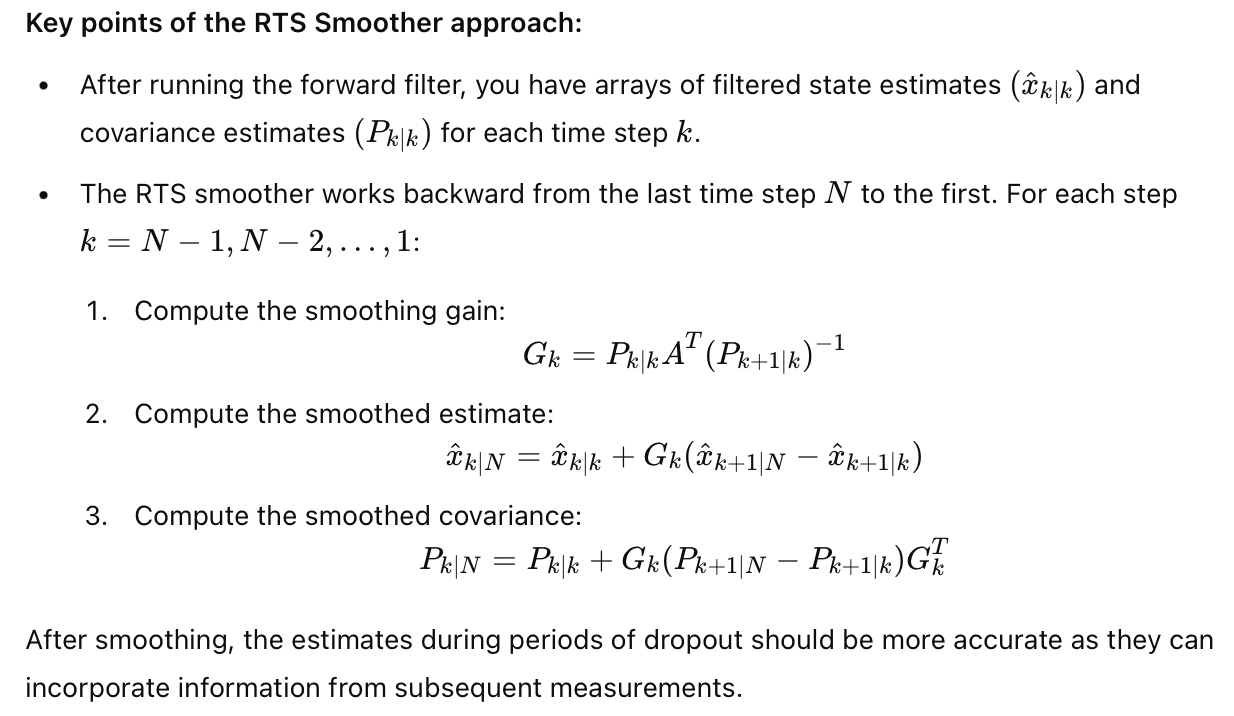


Position Accuracy (Smoothed): 98.17%
Velocity Accuracy (Smoothed): 91.25%

Sample of results (smoothed):
TimeStep | TrueX     TrueY     MeasuredX     MeasuredY     SmoothedX   SmoothedY   TrueVX   TrueVY   SmoothedVX SmoothedVY
      1 |    0.000   10.000        nan        nan     -0.124     21.598  14.142  14.142     14.316     -4.310
      2 |    1.414   11.365      0.570     12.015      1.308     21.167  14.142  14.142     14.316     -4.310
      3 |    2.828   12.632      2.640     13.646      2.754     20.919  14.142  13.161     14.315     -4.328
      4 |    4.243   13.801        nan        nan      4.203     20.815  14.142  12.180     14.312     -4.380
      5 |    5.657   14.872        nan        nan      5.651     20.706  14.142  11.199     14.307     -4.464
      6 |    7.071   15.845        nan        nan      7.098     20.588  14.142  10.218     14.301     -4.581
      7 |    8.485   16.719        nan        nan      8.545     20.459  14.142   9.237     14.293     -4.731
  

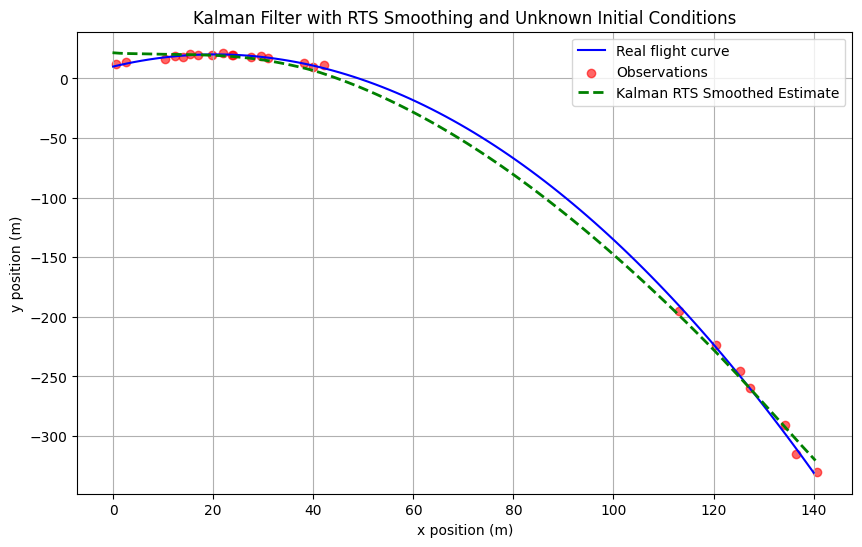

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def rts_smoother(x_filt, P_filt, x_pred, P_pred, A):
    n = x_filt.shape[0]
    x_smooth = np.copy(x_filt)
    P_smooth = np.copy(P_filt)

    for k in range(n-2, -1, -1):
        P_pred_inv = np.linalg.inv(P_pred[k+1])
        G = P_filt[k] @ A.T @ P_pred_inv  # Smoothing gain
        x_smooth[k] = x_filt[k] + G @ (x_smooth[k+1] - x_pred[k+1])
        P_smooth[k] = P_filt[k] + G @ (P_smooth[k+1] - P_pred[k+1]) @ G.T

    return x_smooth, P_smooth

def simulate_kalman_filter_with_smoothing(
    launch_height,
    launch_speed,
    launch_angle,
    measurement_noise_covariance,
    process_noise_covariance,
    initial_state_covariance,
    num_steps,
    dropout_start,
    dropout_end,
    observation_probability
):
    # Gravity and time step
    g = 9.81
    dt = 0.1

    # True initial conditions (unknown to the filter)
    x0 = 0.0
    y0 = launch_height
    vx0 = launch_speed * np.cos(np.radians(launch_angle))
    vy0 = launch_speed * np.sin(np.radians(launch_angle))
    q_true = np.array([x0, y0, vx0, vy0])

    # Since initial position and flying direction are unknown:
    # Assume the ball starts within ±10m range around the real starting position
    # and velocity is also uncertain.
    x0_guess = x0 + np.random.uniform(-10, 10)
    y0_guess = y0 + np.random.uniform(-10, 10)
    # For velocity, assume a moderate guess: we have no idea about direction, pick random from a range
    vx0_guess = np.random.uniform(-5, 5)
    vy0_guess = np.random.uniform(-5, 5)

    q_est = np.array([x0_guess, y0_guess, vx0_guess, vy0_guess])

    # State transition matrix A
    A = np.array([
        [1, 0, dt, 0],
        [0, 1, 0, dt],
        [0, 0, 1,  0],
        [0, 0, 0,  1]
    ])

    # Control matrix B (for gravity)
    B = np.array([
        [0,         0],
        [0.5*dt*dt, 0],
        [0,         0],
        [dt,        0]
    ])

    u = np.array([0, -g])  # control vector

    # Observation matrix C
    C = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0]
    ])

    Q = process_noise_covariance
    R = measurement_noise_covariance

    # Since initial guess is very uncertain, increase initial covariance
    # This reflects our large uncertainty in the initial state.
    P = np.eye(4) * initial_state_covariance * 10  # multiplied by 10 for more uncertainty

    # Storage arrays
    true_positions = np.zeros((num_steps, 4))
    observations = np.full((num_steps, 2), np.nan)
    x_filtered = np.zeros((num_steps, 4))
    P_filtered = np.zeros((num_steps, 4, 4))
    x_predicted = np.zeros((num_steps, 4))
    P_predicted = np.zeros((num_steps, 4, 4))

    true_positions[0, :] = q_true
    x_filtered[0, :] = q_est
    P_filtered[0] = P

    vx, vy = vx0, vy0

    def is_observation_available(t):
        return (np.random.rand() < observation_probability) and not (dropout_start <= t < dropout_end)

    # Forward pass (Filtering)
    for t in range(1, num_steps):
        # True state update
        true_positions[t, 0] = true_positions[t-1, 0] + vx * dt
        true_positions[t, 1] = true_positions[t-1, 1] + vy * dt - 0.5 * g * dt**2
        true_positions[t, 2] = vx
        true_positions[t, 3] = vy
        vy = vy - g * dt

        # Measurement
        if is_observation_available(t):
            observations[t, 0] = true_positions[t, 0] + np.random.normal(0, np.sqrt(R[0,0]))
            observations[t, 1] = true_positions[t, 1] + np.random.normal(0, np.sqrt(R[1,1]))

        # Prediction step
        x_pred = A @ x_filtered[t-1] + B @ u
        P_pred = A @ P_filtered[t-1] @ A.T + Q

        x_predicted[t] = x_pred
        P_predicted[t] = P_pred

        # Update step
        if not np.isnan(observations[t, 0]):
            z = observations[t, :].reshape(-1, 1)
            Hx = C @ x_pred.reshape(-1,1)
            S = C @ P_pred @ C.T + R
            K = P_pred @ C.T @ np.linalg.inv(S)
            x_upd = x_pred.reshape(-1,1) + K @ (z - Hx)
            P_upd = (np.eye(4) - K @ C) @ P_pred

            x_filtered[t] = x_upd.flatten()
            P_filtered[t] = P_upd
        else:
            # No measurement
            x_filtered[t] = x_pred
            P_filtered[t] = P_pred

    # RTS Smoothing
    x_smoothed, P_smoothed = rts_smoother(x_filtered, P_filtered, x_predicted, P_predicted, A)

    # Evaluate results
    estimated_positions = x_smoothed[:, 0:2]
    estimated_velocities = x_smoothed[:, 2:4]

    # Compute RMSE for positions and velocities
    pos_diff = true_positions[:, 0:2] - estimated_positions
    vel_diff = true_positions[:, 2:4] - estimated_velocities

    position_rmse = np.sqrt(np.mean(np.sum(pos_diff**2, axis=1)))
    velocity_rmse = np.sqrt(np.mean(np.sum(vel_diff**2, axis=1)))

    # Calculate ranges
    position_range = (np.max(true_positions[:, 0:2]) - np.min(true_positions[:, 0:2]))
    velocity_range = (np.max(true_positions[:, 2:4]) - np.min(true_positions[:, 2:4]))

    # Compute accuracy metrics
    position_accuracy = 100 * (1 - position_rmse / position_range) if position_range != 0 else 0
    velocity_accuracy = 100 * (1 - velocity_rmse / velocity_range) if velocity_range != 0 else 0

    print(f'Position Accuracy (Smoothed): {position_accuracy:.2f}%')
    print(f'Velocity Accuracy (Smoothed): {velocity_accuracy:.2f}%')

    # Print a sample of results
    print("\nSample of results (smoothed):")
    print("TimeStep | TrueX     TrueY     MeasuredX     MeasuredY     SmoothedX   SmoothedY   TrueVX   TrueVY   SmoothedVX SmoothedVY")
    for i in range(min(num_steps, 10)):
        print(f"{i+1:7d} | {true_positions[i,0]:8.3f} {true_positions[i,1]:8.3f} "
              f"{observations[i,0]:10.3f} {observations[i,1]:10.3f} {x_smoothed[i,0]:10.3f} {x_smoothed[i,1]:10.3f} "
              f"{true_positions[i,2]:7.3f} {true_positions[i,3]:7.3f} {x_smoothed[i,2]:10.3f} {x_smoothed[i,3]:10.3f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(true_positions[:, 0], true_positions[:, 1], 'b-', label='Real flight curve')
    obs_mask = ~np.isnan(observations[:, 0])
    plt.scatter(observations[obs_mask, 0], observations[obs_mask, 1], c='r', marker='o', alpha=0.6, label='Observations')
    plt.plot(x_smoothed[:, 0], x_smoothed[:, 1], 'g--', linewidth=2, label='Kalman RTS Smoothed Estimate')
    plt.title('Kalman Filter with RTS Smoothing and Unknown Initial Conditions')
    plt.xlabel('x position (m)')
    plt.ylabel('y position (m)')
    plt.grid(True)
    plt.legend()
    plt.show()

    return estimated_positions, estimated_velocities, position_accuracy, velocity_accuracy

# Example usage:
if __name__ == "__main__":
    launch_height = 10.0
    launch_speed = 20.0
    launch_angle = 45.0
    measurement_noise_covariance = np.diag([0.5, 0.5])
    process_noise_covariance = np.diag([0.01, 0.01, 0.01, 0.01])
    initial_state_covariance = 50.0   # Larger to reflect bigger initial uncertainty
    num_steps = 100
    dropout_start = 30
    dropout_end = 80
    observation_probability = 0.5

    simulate_kalman_filter_with_smoothing(
        launch_height,
        launch_speed,
        launch_angle,
        measurement_noise_covariance,
        process_noise_covariance,
        initial_state_covariance,
        num_steps,
        dropout_start,
        dropout_end,
        observation_probability
    )
